In [1]:
from pathlib import Path

import torch
import numpy as np
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [2]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params

    @staticmethod
    def extract_files(root):
        files = []
        for subject in root.glob('*'):
            slice_path = subject / 'data'
            for slice in slice_path.glob('*.npy'):
                files.append(slice)

        return files

    @staticmethod
    def change_img_to_label_path(path):
        parts = list(path.parts)
        parts[parts.index('data')] = 'masks'
        return Path(*parts)

    def augment(self, slice, mask):
        random_seed = torch.randint(0, 100000, (1,)).item()
        imgaug.seed(random_seed)

        mask = mask.astype(np.int32)
        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice = np.load(file_path).astype(np.float32)
        mask = np.load(mask_path)

        if self.augment_params:
            slice, mask = self.augment(slice, mask)
        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)


In [3]:
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

In [4]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
               rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

In [5]:
path = Path('Preprocessed/train/')
dataset = CardiacDataset(path, seq)

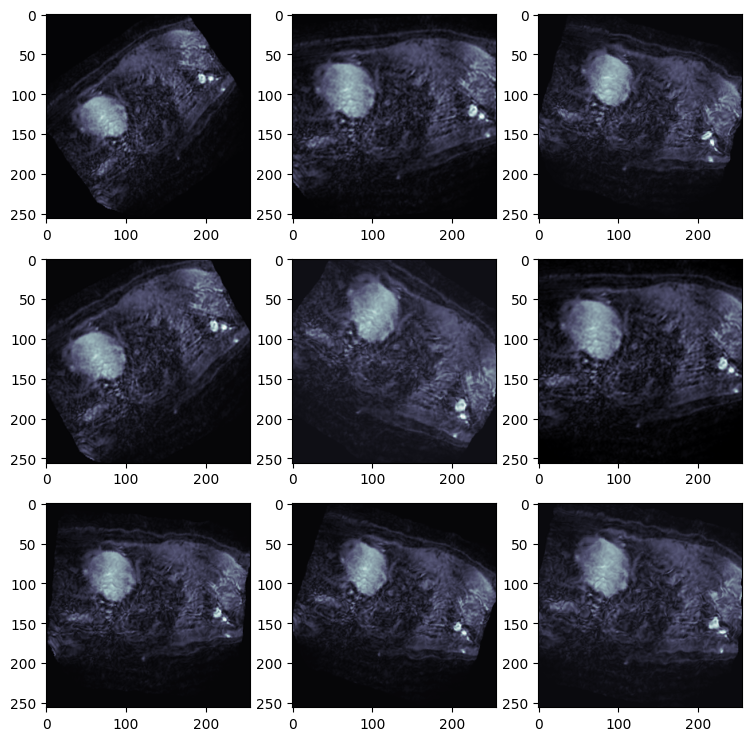

In [7]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    for j in range(3):
        slice, mask = dataset[1]
        mask_ = np.ma.masked_where(mask == 0, mask)
        axis[i][j].imshow(slice[0], cmap='bone')
        axis[i][j].imshow(mask_[0])